<a href="https://colab.research.google.com/github/vbanai/Market-basket-analysis/blob/main/Comprehensive_ecommerce_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot





In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "viktorbanai" # username from the json file
os.environ['KAGGLE_KEY'] = "9431db56af1a1a63cab88b4e516a2248" # key from the json file
!kaggle datasets download -d carrie1/ecommerce-data # api copied from kaggle

  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 103MB/s]


In [ ]:
!mkdir file_destination_ecommerce_data
!unzip -u "/content/ecommerce-data.zip" -d "/content/file_destination_ecommerce_data"

Archive:  /content/ecommerce-data.zip
  inflating: /content/file_destination_ecommerce_data/data.csv  


In [ ]:
#df_initial=pd.read_csv("/content/file_destination_ecommerce_data/data.csv", encoding= 'unicode_escape')
#df_initial.head()

In [ ]:
import pandas as pd
df_initial = pd.read_csv("/content/file_destination_ecommerce_data/data.csv",encoding="ISO-8859-1", 
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [ ]:
df_initial[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Data cleaning

In [ ]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [ ]:
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.Series(df_initial.isnull().sum(), index=tab_info.columns, name='null values (nb)'))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info = tab_info.rename(columns={'InvoiceNo': 'Invoice number'}, index={'null values (nb)': 'number of null values'})
tab_info

,Invoice number,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
number of null values,0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [ ]:
#Drop Nas
df_initial.dropna(subset = ['CustomerID'], inplace = True)

In [ ]:
# Sum and drop duplicates
df_initial.duplicated().sum()
df_initial.drop_duplicates(inplace = True)

Creating Choropleth to check the geographical distribution of the transactions

In [ ]:
#1 method (Some countries are not showed for example South Africa, maybe because the country names in the preset libary is different to the current database's country names)

temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()   #maybe there is another method to get the value in multiindexing
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

fig=go.Figure(data = [data], layout = layout)
fig.show(renderer="colab")

In [ ]:
#2. method (Some countries in the database are not in the downloaded map libary, but in this method I can control and check the countries)

import json
world_map=json.load(open("/content/custom.geo.json", "r"))  # I have uploaded a downloaded geo.json file
world_map['features'][2]['properties']  #I need admin 

In [ ]:
country_id={}  
for feature in world_map['features']:
  feature['id']=feature['properties']['brk_a3']
  country_id[feature['properties']['admin']]=feature['id']  #create pairs for example  'Czech Republic':'CZE'

In [ ]:
#I have to rename some countires in the dataset to match the json file naming
#for example in the json file Hong Kong or Singapure is not indicated just Chine, 
#so in the dataset I changed this two country name to Chine, to see the geographical distribution somehow

df_initial_map=df_initial.copy(deep=True)

df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "EIRE"].index, 'Country'] = 'Ireland'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Channel Islands"].index, 'Country'] = 'France'
df_initial_map.loc[df_initial_map['Country'] == "Channel Islands"].index
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Bahrain"].index, 'Country'] = 'Saudi Arabia'
df_initial_map.loc[df_initial_map['Country'] == "Bahrain"].index
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Hong Kong"].index, 'Country'] = 'China'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Singapore"].index, 'Country'] = 'China'
df_initial_map.drop(df_initial_map[df_initial_map['Country'] == "Unspecified"].index, inplace = True)
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "USA"].index, 'Country'] = 'United States of America'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "European Community"].index, 'Country'] = 'Germany'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Malta"].index, 'Country'] = 'Italy'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "RSA"].index, 'Country'] = 'South Africa'

In [ ]:
df_initial_map['id']=df_initial_map['Country'].apply(lambda x:country_id[x])  # create a new country ID coloumn

In [ ]:
countries = df_initial_map['Country'].value_counts()
countries=countries.to_frame()
countries.rename(columns={'Country':'Number of orders'}, inplace=True)
countries['Country'] = countries.index
countries.reset_index(inplace=True)
del countries['index']
countries['id']=countries['Country'].apply(lambda x:country_id[x])
countries

In [ ]:

!pip install plotly==4.5. 0
import plotly.express as px

     |████████████████████████████████| 7.1 MB 31.4 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import numpy as np
countries['Number of ordersScale']=np.log10(countries['Number of orders'])  # because of the outliers we have to normalize the data somehow to have clearer plot
fig=px.choropleth(countries, locations='id', geojson=world_map, color="Number of ordersScale")
fig.show(renderer="colab")

Exploring the dataset

In [ ]:
# Check the number of products, customers and transactions

q={
    "Product_q": len(df_initial['StockCode'].value_counts()),
    "Customer_q": len(df_initial['CustomerID'].value_counts()),
    "Transation_q": len(df_initial['InvoiceNo'].value_counts())
}
Quantities=pd.DataFrame(q, index = ['quantity'])
Quantities

,Product_q,Customer_q,Transation_q
quantity,4070,4372,25900


In [ ]:
# Check the cancellation (MULTIINDEXING)

temp = df_initial.groupby(by=['InvoiceNo', 'CustomerID'])
#temp.get_group('536365')['Quantity'].sum()

Number_of_products=temp['StockCode'].count().to_frame()
Number_of_products.rename({'StockCode':'Number of products'}, axis=1, inplace=True)
Number_of_products_reset= Number_of_products.reset_index()

Number_of_products_reset
Number_of_products_reset.loc[Number_of_products_reset['CustomerID']=='12346']
Number_of_products_reset

,InvoiceNo,CustomerID,Number of products
0,536365,17850,7
1,536366,17850,2
2,536367,13047,12
3,536368,13047,4
4,536369,13047,1
...,...,...,...
22185,C581484,16446,1
22186,C581490,14397,2
22187,C581499,15498,1
22188,C581568,15311,1


In [ ]:
len(Number_of_products_reset['Number of products'])

22190

In [ ]:
Number_of_products_reset['Cancellation'] = Number_of_products_reset['InvoiceNo'].apply(lambda x:int('C' in x))
Number_of_products_reset

,InvoiceNo,CustomerID,Number of products,Cancellation
0,536365,17850,7,0
1,536366,17850,2,0
2,536367,13047,12,0
3,536368,13047,4,0
4,536369,13047,1,0
...,...,...,...,...
22185,C581484,16446,1,1
22186,C581490,14397,2,1
22187,C581499,15498,1,1
22188,C581568,15311,1,1


In [ ]:
Cancellation_number=len(Number_of_products_reset[Number_of_products_reset['Cancellation']==1])
Cancellation_number

3654

In [ ]:
#Sorting the dataset by the CustomerID

df_initial.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


Distribution of the purchased amounts

In [ ]:
df_initial2=df_initial.copy(deep=True)

#InvoiceNo of a cancelled item starts with C:
df_initial2.loc[df_initial2['InvoiceNo']=='C541433']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


In [ ]:
#make  a cancellation column
df_initial2["Cancellation"]=df_initial2['InvoiceNo'].apply(lambda x: int("C" in x))
df_initial2

In [ ]:
#len(df_initial2.loc[df_initial2["Cancellation"]==0])
len(df_initial2.loc[df_initial2["Cancellation"]==1])

8872

In [ ]:
#Cancellation number:
f=df_initial2.loc[df_initial2["Cancellation"]==1].groupby(["InvoiceNo"]).count()
len(f)

3654

In [ ]:
# Dropping cancellation and check the min and max amount


initial2=df_initial2.drop(df_initial2.index[df_initial2["Cancellation"] == 1], inplace = True)

df_initial2['Total amount']=df_initial2['Quantity'] * df_initial2['UnitPrice']
print(min(df_initial2['Total amount']), max(df_initial2['Total amount']))
df_initial2.loc[df_initial2['Total amount']==168469.6]

0.0 168469.6


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Total amount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,0,168469.6


In [ ]:
temp=df_initial2.groupby(by=df_initial2['InvoiceNo'])

Amount_by_invoices=temp['Total amount'].sum().to_frame()


Amount_by_invoices=Amount_by_invoices.reset_index()
print(min(Amount_by_invoices['Total amount']), max(Amount_by_invoices['Total amount']))

0.0 168469.6


In [ ]:
Amount_by_invoices

,InvoiceNo,Total amount
0,536365,139.12
1,536366,22.20
2,536367,278.73
3,536368,70.05
4,536369,17.85
...,...,...
18531,581583,124.60
18532,581584,140.64
18533,581585,329.05
18534,581586,339.20


In [ ]:
price_range = [0, 1000, 80000, 140000, 170000]

count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = Amount_by_invoices[(Amount_by_invoices['Total amount'] < price) &
                       (Amount_by_invoices['Total amount'] > price_range[i-1])]['Total amount'].count()
    count_price.append(val)

In [ ]:
count_price

[17218, 1312, 0, 1]

In [ ]:
import plotly           
import plotly.express as px
import plotly.io as pio




#plt.rc('font', weight='bold')
#f, ax = plt.subplots(figsize=(11, 6))
colors = [ 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{} USD'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
          

sizes  = count_price

#p for p in count_prize

pie_chart = px.pie(
    
        values=count_price,
        names=labels,
        color=colors,                     
       
        labels={"state":"the State"},      
        title='Distribution of the invoice amounts',     
        template='presentation',           
                                          
        width=800,                          
        height=600,                         
        hole=0.2,                          
        )

pio.show(pie_chart, renderer="colab")

Market Basket Analisis

In [ ]:
#Finding the word-formations most frequently appeared in the descriptions which contains 4 or more words

# counting and splitting the descriptions

t=df_initial.Description.value_counts().to_frame()
t=t.reset_index()
t=t.rename(columns={'index': 'Description', 'Description':'Sum'})
#t['check']=t.Description.apply(lambda x: int("HEART T-LIGHT" in x))
#t.loc[t.check==1]
t=t.Description.str.split(" ")
#nodigit_list = [item for k in t for item in k if not item.isdigit()]
#nodigit_list
tt=[]
for i in t:
  a=[item for item in i if not item.isdigit() and item!='' ]
  tt.append(a)

t

0         [WHITE, HANGING, HEART, T-LIGHT, HOLDER]
1                    [REGENCY, CAKESTAND, 3, TIER]
2                     [JUMBO, BAG, RED, RETROSPOT]
3                                 [PARTY, BUNTING]
4               [ASSORTED, COLOUR, BIRD, ORNAMENT]
                           ...                    
3891    [GLASS, AND, PAINTED, BEADS, BRACELET, OL]
3892                [PINK, ROUND, COMPACT, MIRROR]
3893              [PINK, BOUDOIR, T-LIGHT, HOLDER]
3894        [WHITE/PINK, MINI, CRYSTALS, NECKLACE]
3895      [FLOWER, GLASS, GARLD, NECKL36"TURQUOIS]
Name: Description, Length: 3896, dtype: object

In [ ]:
#Create token for the  words in the descriptions

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=4000, oov_token="<OOV>") #create instance num_words applies to the sequence, OOV is used for words there aren't in the indexlist
tokenizer.fit_on_texts(t)  # encodes the data, create the dict
word_index = tokenizer.word_index 
seq = tokenizer.texts_to_sequences(tt)
word_index

In [ ]:


seq2=[x for x in seq if len(x)>=4]

unwanted_elements=[230, 5, 39, 36, 827, 1600 ]
cleared_seq=[]
for k in seq2:
  a=[x for x in k if x not in unwanted_elements]
  cleared_seq.append(a)
len(cleared_seq)

3112

In [ ]:
# most frequent word formations in the descriptions

most_common_expressions=[]



for i in cleared_seq:
  for k in cleared_seq:
    intersection=set(i).intersection(k)
  #  unwanted_elements=[230, 5, 39, 36, 827, 1600 ]
    # cleared_i=[x for x in i if x not in unwanted_elements]
  # cleared_intersection=[x for x in intersection if x not in unwanted_elements]
    if cleared_seq.index(i)!=cleared_seq.index(k) and len(intersection)>=3 and intersection not in most_common_expressions:
        most_common_expressions.append(intersection)


most_common_expressions


In [ ]:
most_common_expressions

In [ ]:
# Untokenizing the most frequent wordformations

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    final_list=[]
    for i in list_of_indices:
      words = [reverse_word_map.get(letter) for letter in i]
      final_list.append(words)
    return(final_list)


most_common_expressions_towords=sequence_to_text(most_common_expressions)
most_common_expressions_towords

In [ ]:
# make the splitted original description to lower case

k=t.tolist()
lower_case_original_list=[]
for i in k:
  lower_case_original_list.append([x.lower() for x in i])
lower_case_original_list

In [ ]:
# make the original description
k=df_initial.Description.str.split(" ")
h=k.tolist()
lower_case_original_list=[]
for i in h:
  p=[]
  for k in i:
    p.append(k.lower())
  lower_case_original_list.append(p)
lower_case_original_list

In [ ]:
# Creating the final list with the most frequent word formation with their occurance

Final_list=[]

most_common_expressions_towords
for k in most_common_expressions_towords:
  counter=0
  for i in lower_case_original_list:
    result = all(elem in i for elem in k)
    if result==True:
      counter +=1
  Final_list.append([k, counter])
 

Final_list


In [ ]:
lower_case_original_list[0]

['white', 'hanging', 'heart', 't-light', 'holder']

In [ ]:
for i in Final_list:

  if i[0]==['heart']:
   print(i[1])

235


In [ ]:
import copy
Final_list2=copy.deepcopy(Final_list)

The_50_most_frequent_workdformation=[]

for i in range(50):
  max=0
  for i in range(len(Final_list2)):
    if Final_list2[i][1]>max:
      max=Final_list2[i][1]
  
  for q in range(len(Final_list2)):
    if Final_list2[q][1]==max:

      The_50_most_frequent_workdformation.append([Final_list2[q][0], max])
      Final_list2.remove(Final_list2[q])
      break
  #for k in range(len(Final_list2)):
    ##print(Final_list2[k][1], '------', Final_list2[k][1])
   # if Final_list2[k][1]==max:
      ##print(Final_list2[k],"-----",Final_list2[k][1], "----------", max)
    #  Final_list2.remove(Final_list2[k])
     # break
    
The_50_most_frequent_workdformation

In [ ]:
a1=[]
a2=[]
lista=[]
for k in range(50):
  lista.append(k)

for i in The_50_most_frequent_workdformation:
  a1.append(i[0])
  a2.append(i[1])


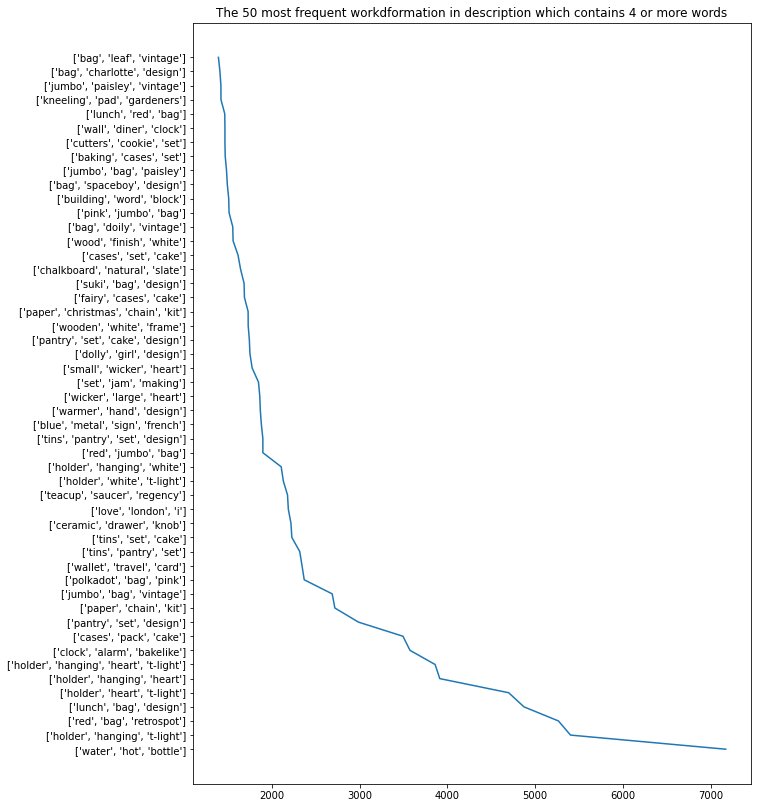

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10,14)
y = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49])
x = np.array(a2)
my_yticks = a1
plt.yticks(y, my_yticks)
plt.plot(x, y)
plt.title("The 50 most frequent workdformation in description which contains 4 or more words")
plt.show()


In [ ]:
liste_produits = df_initial['Description'].unique()
liste_produits

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

keywords_inventory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<function __main__.keywords_inventory>

In [ ]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)


Nb of keywords in variable 'Description': 1483


In [ ]:
keywords

In [ ]:
#StockCodes

temp = df_initial.groupby(by=['CustomerID', 'StockCode'])
#temp.get_group('536365')['Quantity'].sum()

Number_of_products=temp['StockCode'].count().to_frame()
Number_of_products.rename({'StockCode':'Number of products'}, axis=1, inplace=True)
Number_of_products_reset= Number_of_products.reset_index()

Number_of_products_reset
Number_of_products_reset.loc[Number_of_products_reset['CustomerID']=='12346']
Stock_codes=Number_of_products_reset.values.tolist()
Stock_codes


In [ ]:
counter=0
for i in range(0, len(Stock_codes)-1):
  if Stock_codes[i][0]!=Stock_codes[i+1][0]:
    counter+=1
counter


4371

In [ ]:
 Stock_codes=[['12362', '22892', 1],
 ['12362', '22900', 1],
 ['12362', '22904', 1],
 ['2222', '22908', 2],
 ['2222', '22930', 1],
 ['3333', '22937', 1],
 ['3333', '22940', 1],
 ['4444', '22941', 2]]

In [ ]:
Stock_codes_fordf=[]
temporary_folder=[]
for i in range(0, len(Stock_codes)-1):
  if Stock_codes[i][0]==Stock_codes[i+1][0]:
    if Stock_codes[i][1] not in temporary_folder:
     
      temporary_folder.append(Stock_codes[i][1])
    if Stock_codes[i+1][1] not in temporary_folder:
      temporary_folder.append(str(Stock_codes[i+1][1]))
  
  if Stock_codes[i][0]!=Stock_codes[i+1][0]:
    if Stock_codes[i][1] not in temporary_folder:
      temporary_folder.append(str(Stock_codes[i][1]))
    
    Stock_codes_fordf.append(temporary_folder)
    temporary_folder=[]
  if Stock_codes[i][0]!=Stock_codes[i+1][0] and (i+2)==len(Stock_codes):
   
    temporary_folder.append(str(Stock_codes[i+1][1]))
    Stock_codes_fordf.append(temporary_folder)

Stock_codes_fordf




In [ ]:
for i in Stock_codes_fordf:
  for k in i:
    if k=="22698, 22423, 22697":
      print("ok")

In [ ]:
Stock_codes_pd=pd.DataFrame(Stock_codes_fordf)
Stock_codes_pd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793
0,23166,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,16008,17021,20665,20719,20780,20782,20966,21035,21041,21064,21154,21171,21265,21578,21636,21731,21791,21832,21975,21976,22131,22134,22195,22196,22212,22252,22371,22372,22374,22375,22376,22417,22422,22423,22432,22492,22494,22497,22550,22561,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,21211,21213,21725,21726,21967,21977,21980,21981,21982,21983,21985,22437,22616,22951,22952,23076,23077,23078,84988,84991,84992,POST,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,20685,20914,21086,21136,21231,21232,21411,21531,21533,21535,21563,21564,21787,22059,22064,22070,22071,22131,22195,22326,22333,22423,22430,22441,22553,22554,22555,22556,22557,22567,22601,22666,22692,22704,22720,22722,22832,22960,23020,23108,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,20615,20652,21171,21832,21864,21866,21908,21915,22348,22412,22551,22557,22620,79066K,79191C,84086C,POST,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,20914,22111,22114,22595,22596,22727,23301,23355,23404,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4367,22084,22180,22358,22467,22495,22499,22611,22725,22727,82484,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4368,22028,22037,22467,22716,23007,23008,23209,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

In [ ]:
print(Stock_codes_pd.dtypes)

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


encoder=TransactionEncoder().fit(Stock_codes_fordf)
onehot=encoder.transform(Stock_codes_fordf)
onehot=pd.DataFrame(onehot, columns=encoder.columns_)
onehot


,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,15030,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16010,16011,16012,16014,16015,16016,16020C,16033,16043,16045,16046,16048,16049,16052,...,90210A,90210B,90210C,90210D,90211A,90211B,90212B,90212C,90214A,90214B,90214C,90214D,90214E,90214F,90214G,90214H,90214I,90214J,90214K,90214L,90214M,90214N,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4367,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [ ]:
te=TransactionEncoder()
te_ary=te.fit(Stock_codes_pd).transform(Stock_codes_pd)

True_False_DF=pd.DataFrame(te_ary, columns=te.columns_)
True_False_DF

,\n,,0,1,2,3,4,5,6,7,8,9,N,e,n,o
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47082062,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
47082063,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
47082064,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
47082065,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
frequent_itemsets=apriori(onehot, min_support=0.05, use_colnames=True)
print(frequent_itemsets)

      support                      itemsets
0    0.075269                       (20685)
1    0.056738                       (20712)
2    0.054221                       (20718)
3    0.054450                       (20719)
4    0.053077                       (20723)
..        ...                           ...
359  0.056509         (22698, 22423, 22697)
360  0.059941         (22699, 22423, 22697)
361  0.053535         (22698, 22699, 22423)
362  0.060169         (22698, 22699, 22697)
363  0.051704  (22698, 22699, 22423, 22697)

[364 rows x 2 columns]


In [ ]:
rules=association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(20725),(20726),0.121711,0.085335,0.057424,0.471805,5.528841,0.047038,1.731679
1,(20726),(20725),0.085335,0.121711,0.057424,0.672922,5.528841,0.047038,2.685260
2,(20725),(20727),0.121711,0.104782,0.068634,0.563910,5.381768,0.055881,2.052829
3,(20727),(20725),0.104782,0.121711,0.068634,0.655022,5.381768,0.055881,2.545926
4,(20725),(20728),0.121711,0.110043,0.070464,0.578947,5.261079,0.057071,2.113647
...,...,...,...,...,...,...,...,...,...
245,"(22423, 22697)","(22698, 22699)",0.068634,0.062457,0.051704,0.753333,12.061612,0.047418,3.800850
246,(22698),"(22699, 22423, 22697)",0.073439,0.059941,0.051704,0.704050,11.745809,0.047302,3.176412
247,(22699),"(22698, 22423, 22697)",0.097689,0.056509,0.051704,0.529274,9.366221,0.046184,2.004332
248,(22423),"(22698, 22699, 22697)",0.202928,0.060169,0.051704,0.254791,4.234575,0.039494,1.261165


Clustering


In [ ]:
# First I try to create cluster in relation of "Description" and "Unit price"
#Creating description ID which the unit price can be ordered to

description_count=df_initial.Description.value_counts().to_frame()
description_count=description_count.index.tolist()


In [ ]:
description=df_initial.Description.values.tolist()
len(description)

In [ ]:
countering=[]
for p in range(401604):
  countering.append(0)



In [ ]:


for i in range(len(description)):
  for k in range(len(description_count)):
    if descripton[i]==description_count[k]:
      countering[i]=k+1

max(countering)


In [ ]:
df_initial['description ID']=countering
df_initial

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sse = []  #sum of squarred error
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_initial[["UnitPrice", "description ID"]])
    sse.append(km.inertia_)

In [ ]:
#Somehow Silhouette Score run very very slowly, so I skip checking K means

from tqdm import tqdm
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster

silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(df_initial[["UnitPrice", "description ID"]])
    silhouette[i] = silhouette_score(df_initial[["UnitPrice", "description ID"]], kmeans.labels_, metric='euclidean')



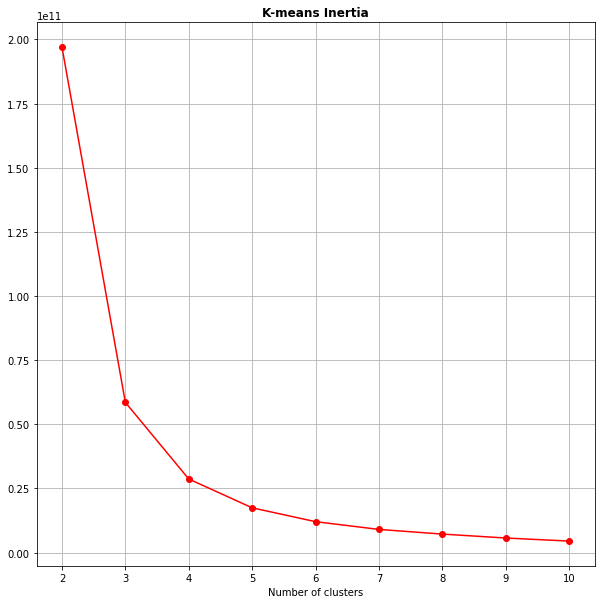

In [ ]:
plt.subplot(1, 1, 1)

plt.plot(range(2,len(k_rng)+2), sse, marker='o',color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)



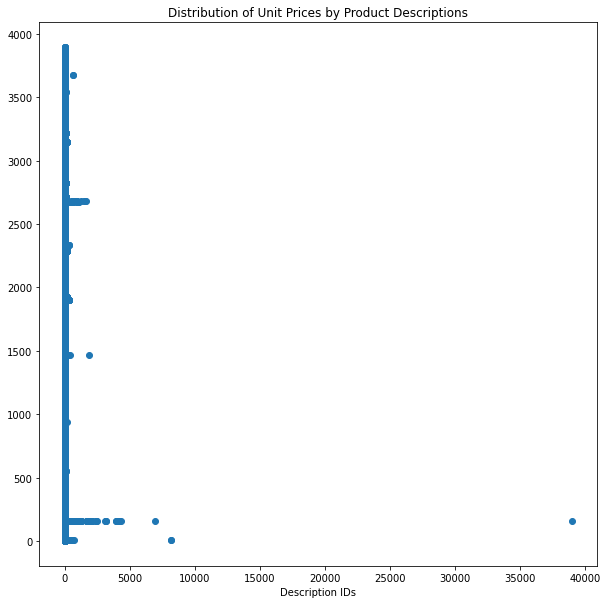

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(df_initial["UnitPrice"], df_initial["description ID"])#, color=my_colors)
#plt.xticks(rotation=90)
plt.xlabel('Description IDs')
plt.title('Distribution of Product Descriptions by Unit Prices')
plt.show()

In [81]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_initial[["UnitPrice", "description ID"]])
#data_cluster2['cluster']=y_predicted
#cluster_numbers = data_cluster2.pivot_table(columns=['cluster'], aggfunc='size')
#print(cluster_numbers)
y_predicted

array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [82]:
df_initial['Clusters'] = y_predicted.tolist()


In [83]:
centroids=km.cluster_centers_
#centroids_pca = pca_2.fit_transform(centroids)
#centroids_pca
centroids

array([[   3.66146668,  233.30105508],
       [   3.93742314, 2195.00682489],
       [   2.87578227, 1050.75344758]])

In [84]:
df1=df_initial[df_initial.Clusters==0]
df2=df_initial[df_initial.Clusters==1]
df3=df_initial[df_initial.Clusters==2]


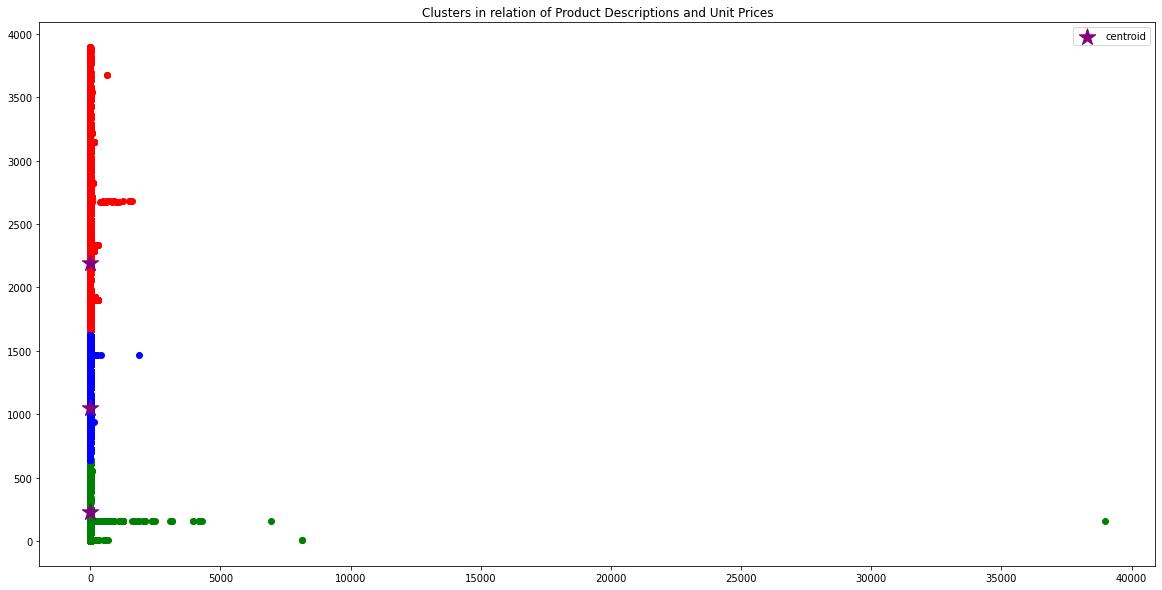

In [86]:
plt.figure(figsize=(20, 10))
plt.scatter(df1["UnitPrice"], df1["description ID"], color='green')

plt.scatter(df2["UnitPrice"], df2["description ID"], color='red')
plt.scatter(df3["UnitPrice"], df3["description ID"], color='blue')


plt.scatter(centroids[:,0],centroids[:,1],color='purple',marker='*', s=300, label='centroid')
plt.title('Clusters in relation of Product Descriptions and Unit Prices')
plt.legend()



In [ ]:
#Plotting the Mean price of the 50 most frequent workdformation in description which contains 4 or more words

len(lower_case_original_list)

In [ ]:
price=df_initial.UnitPrice.to_list()
price2=[]
for i in price:
  price2.append([i])
price2[0]


[2.55]

In [ ]:
Description_UnitPrice=[]
for i in range(len(lower_case_original_list)):

  Description_UnitPrice.append([lower_case_original_list[i], price2[i]])

In [ ]:
Description_UnitPrice[0][0]
The_50_most_frequent_workdformation[0][0]

In [ ]:
Clusterdf=[]
for k in The_50_most_frequent_workdformation:
  
  Temporary=[]
  print(Temporary)
  Temporary.append(k[0])
  for i in Description_UnitPrice:
    result = all(elem in i[0] for elem in k[0])
    if result==True:
      Temporary.append(i[1])
  Clusterdf.append(Temporary)




In [ ]:
The_50_most_frequent_workdformation

In [ ]:
len(Clusterdf)

In [ ]:
sum=0

for i in range(1,len(Clusterdf[0])):
  sum+=Clusterdf[0][i][0]

sum/len(Clusterdf[0])-1

3.4397769102066302

In [ ]:
Clusterdf_mean=[]

for i in range(len(Clusterdf)):
  a=len(Clusterdf[i])
  Sum=0
  for k in range(1,a):
    
    
    Sum+=Clusterdf[i][k][0]
  mean=Sum/a-1
  Clusterdf_mean.append([Clusterdf[i][0], mean, i+1])





Clusterdf_mean

In [ ]:
Clusterdf[0:3][1]

In [ ]:
Clusterdf_mean
Cluster_data=pd.DataFrame(Clusterdf_mean)
Cluster_data.columns = ['WordFormation',"Mean Price", "WordFormationSerialnumber"]
Cluster_data = Cluster_data[["WordFormation", "WordFormationSerialnumber", "Mean Price"]]

Cluster_data[["WordFormationSerialnumber", "Mean Price"]]

In [ ]:
#No need for scaling

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

Cluster_data[[ "Mean Price"]]=std_scaler.fit_transform(Cluster_data[[ "Mean Price"]])

Cluster_data


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

sse = []  #sum of squarred error
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(Cluster_data[["WordFormationSerialnumber", "Mean Price"]])
    sse.append(km.inertia_)

In [ ]:
#silhouette score to validate the elbow rule
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster

silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(Cluster_data[["WordFormationSerialnumber", "Mean Price"]])
    silhouette[i] = silhouette_score(Cluster_data[["WordFormationSerialnumber", "Mean Price"]], kmeans.labels_, metric='euclidean')


100%|██████████| 8/8 [00:00<00:00, 18.37it/s]


Text(0.5, 0, 'Number of Clusters')

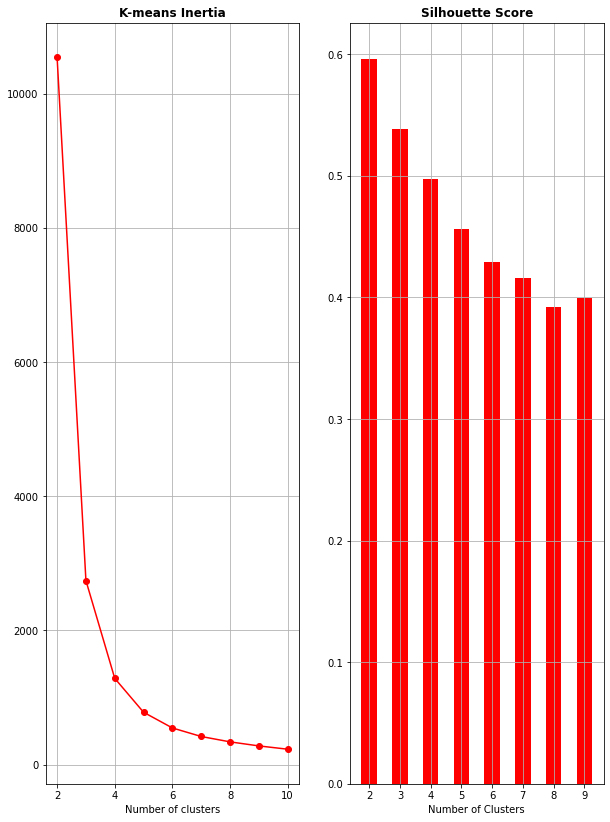

In [ ]:
plt.subplot(1, 2, 1)

plt.plot(range(2,len(k_rng)+2), sse, marker='o',color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'red',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Number of Clusters')

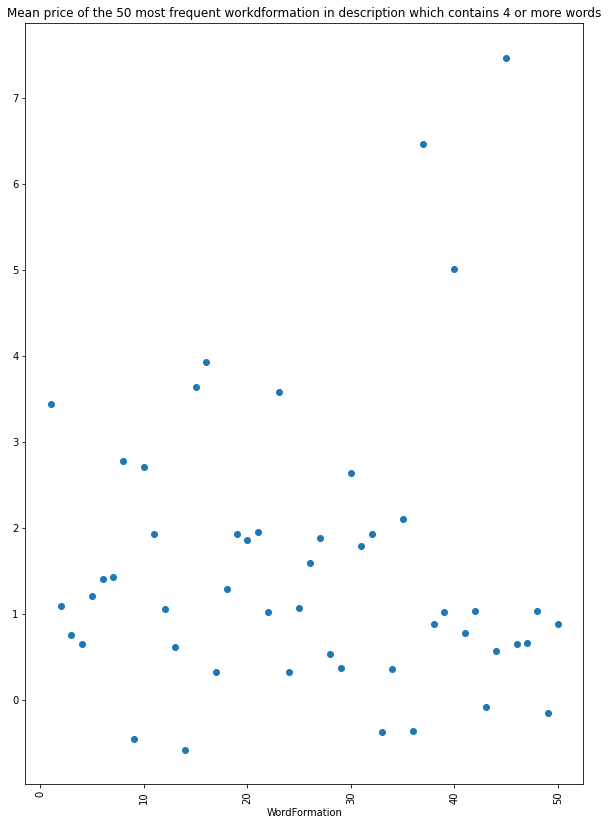

In [ ]:
plt.rcParams["figure.figsize"] = (10,14)
plt.scatter(Cluster_data["WordFormationSerialnumber"], Cluster_data["Mean Price"])#, color=my_colors)
plt.xticks(rotation=90)
plt.xlabel('WordFormation')
plt.title('Mean price of the 50 most frequent workdformation in description which contains 4 or more words')
plt.show()

In [ ]:
#According to the Silhouette score there is no point in creating clusters
#For fun : Elbow rule suggest 4 clusters

km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(Cluster_data[["WordFormationSerialnumber", "Mean Price"]])
#data_cluster2['cluster']=y_predicted
#cluster_numbers = data_cluster2.pivot_table(columns=['cluster'], aggfunc='size')
#print(cluster_numbers)
y_predicted



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
Clusters=pd.Series(y_predicted).value_counts()
Clusters

1    13
0    13
3    12
2    12
dtype: int64

In [ ]:
Cluster_data['Clusters'] = y_predicted.tolist()
Cluster_data

In [ ]:

#from sklearn.decomposition import PCA
#pca_2 = PCA(2)
#pca_2_result = pca_2.fit_transform(Cluster_data[["WordFormationSerialnumber", "Mean Price"]])


centroids=km.cluster_centers_
#centroids_pca = pca_2.fit_transform(centroids)
#centroids_pca
centroids

array([[19.        ,  1.61145486],
       [44.        ,  1.52131337],
       [ 6.5       ,  1.50080814],
       [31.5       ,  1.57738682]])

In [ ]:
Cluster_data["WordFormation"]

In [ ]:
Cluster_data2=Cluster_data.copy(deep=True)
Cluster_data2['WordFormation']= Cluster_data2['WordFormation'].apply(lambda x: str(x)[1:-1])
Cluster_data2

In [ ]:
df1=Cluster_data2[Cluster_data2.Clusters==0]
df2=Cluster_data2[Cluster_data2.Clusters==1]
df3=Cluster_data2[Cluster_data2.Clusters==2]
df4=Cluster_data2[Cluster_data2.Clusters==3]

In [ ]:
df1_word=df1['WordFormation'].tolist()
df1_mean=df1['Mean Price'].tolist()
df2_word=df2['WordFormation'].tolist()
df2_mean=df2['Mean Price'].tolist()
df3_word=df3['WordFormation'].tolist()
df3_mean=df3['Mean Price'].tolist()
df4_word=df4['WordFormation'].tolist()
df4_mean=df4['Mean Price'].tolist()


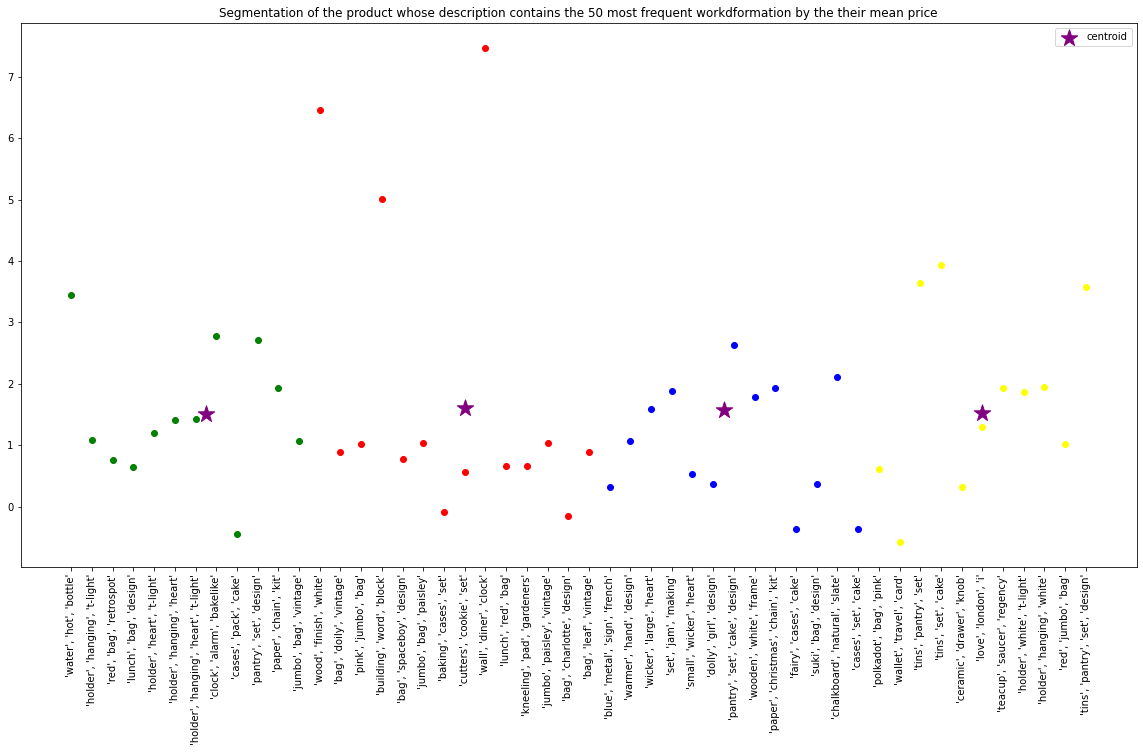

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(df1_word, df1_mean, color='green')

plt.scatter(df2_word, df2_mean, color='red')
plt.scatter(df3_word, df3_mean, color='blue')
plt.scatter(df4_word, df4_mean, color='yellow')
plt.xticks(rotation=90)
plt.scatter(centroids[:,0],centroids[:,1],color='purple',marker='*', s=300, label='centroid')
plt.title('Segmentation of the product whose description contains the 50 most frequent workdformation by the their mean price')
plt.legend()

In [ ]:
df1_word

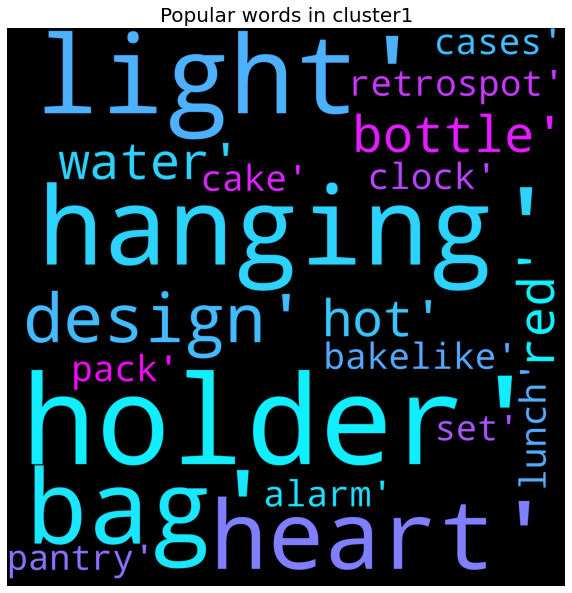

In [ ]:
from wordcloud import WordCloud


wordcloud = WordCloud(width = 6000,  height = 6000, max_words = 20, colormap='cool').generate(str(df1_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Popular words in cluster1',fontsize = 20)
plt.show()

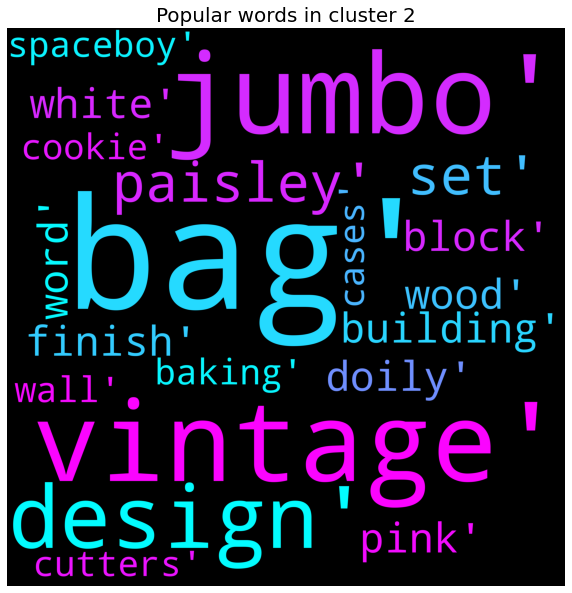

In [ ]:
wordcloud = WordCloud(width = 6000,  height = 6000, max_words = 20, colormap='cool').generate(str(df2_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Popular words in cluster 2',fontsize = 20)
plt.show()

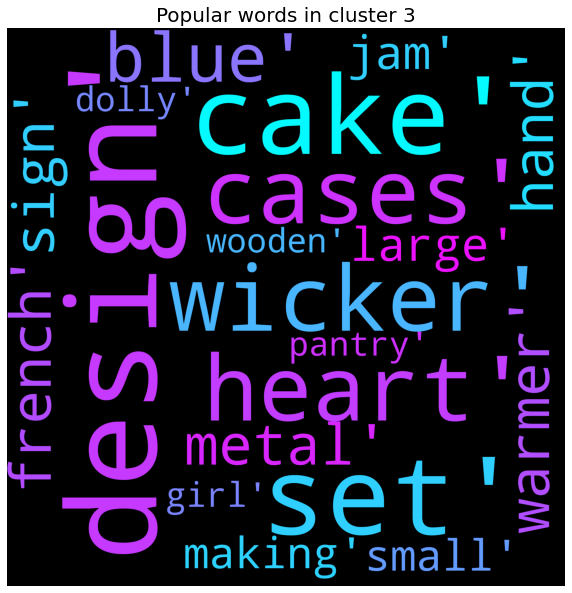

In [ ]:
wordcloud = WordCloud(width = 6000,  height = 6000, max_words = 20, colormap='cool').generate(str(df3_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Popular words in cluster 3',fontsize = 20)
plt.show()

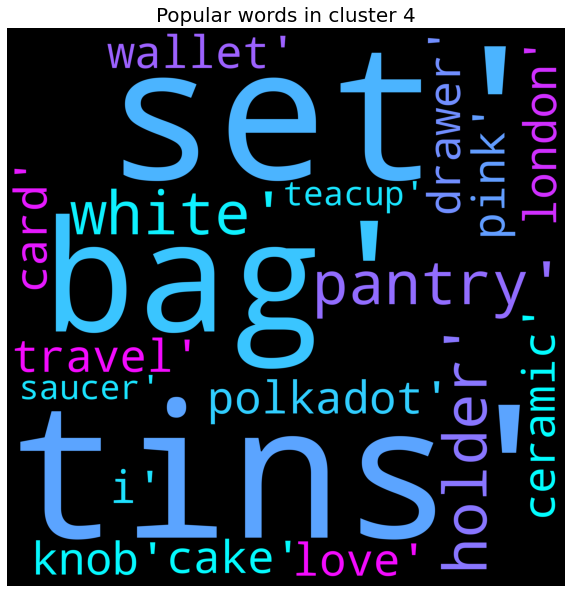

In [ ]:
wordcloud = WordCloud(width = 6000,  height = 6000, max_words = 20, colormap='cool').generate(str(df4_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Popular words in cluster 4',fontsize = 20)
plt.show()